In [6]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from shap import TreeExplainer
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

In [7]:
def evaluate_model_opt(X_train, X_val, y_train, y_val):
    model = XGBClassifier(random_state=42, enable_categorical=True, scale_pos_weight=2)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)
    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred), model

In [8]:
def individual_log_loss(y_true, y_pred, eps=1e-15):
    """Compute log-loss for each individual of the sample."""

    y_pred = np.clip(y_pred, eps, 1 - eps)
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def shap_sum2proba(shap_sum):
    """Compute sigmoid function of the Shap sum to get predicted probability."""

    return 1 / (1 + np.exp(-shap_sum))

def get_preds_shaps(X_train, X_val, y_train, y_val, is_train=True):
    """Get predictions (predicted probabilities) and SHAP values for a dataset."""
    f1, model = evaluate_model_opt(X_train, X_val, y_train, y_val, )
    
    X=None
    y=None
    
    if is_train == True:
        X = X_train.copy()
    else:
        X = X_val.copy()
    
    preds = pd.Series(model.predict_proba(X)[:,1], index=X.index)
    shap_explainer = TreeExplainer(model)
    
    shap_values = shap_explainer.shap_values(X)
    shap_expected_value = shap_explainer.expected_value
    
    shaps = pd.DataFrame(
        data=shap_values,
        index=X.index,
        columns=X.columns)
    return preds, shaps, shap_expected_value

def get_feature_contributions(y_true, y_pred, shap_values, shap_expected_value):
  """Compute prediction contribution and error contribution for each feature."""

  prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")
  
  ind_log_loss = individual_log_loss(y_true=y_true['result_match'], y_pred=y_pred).rename("log_loss")
  y_pred_wo_feature = shap_values.apply(lambda feature: shap_expected_value + shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
  ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true['result_match'], y_pred=feature))
  ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
  error_contribution = ind_log_loss_diff.mean().rename("error_contribution").T
  
  return prediction_contribution, error_contribution

In [9]:
X = pd.read_csv('../data/new_features/df_.csv')
y = pd.read_csv('../data/new_features/y.csv')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
accuracy = []
recall = []
roc_auc = []
precision = []
f1 = []

model = XGBClassifier(random_state=42, enable_categorical=True, scale_pos_weight=2)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)

y_pred = model.predict(X_val)

accuracy.append(round(accuracy_score(y_val, y_pred), 4))
recall.append(round(recall_score(y_val, y_pred), 4))
roc_auc.append(round(roc_auc_score(y_val, y_pred), 4))
precision.append(round(precision_score(y_val, y_pred), 4))
f1.append(round(f1_score(y_val, y_pred), 4))

model_names = ['XGBoost_adjusted_weight_5']
result_df6 = pd.DataFrame({'Accuracy': accuracy, 'Recall': recall, 'Roc_Auc': roc_auc, 'Precision': precision, 'F1': f1}, index=model_names)
result_df6

,Accuracy,Recall,Roc_Auc,Precision,F1
XGBoost_adjusted_weight_5,0.6053,0.7626,0.6177,0.5492,0.6386


In [11]:
explainerxgb = shap.TreeExplainer(model)
shap_values_XGBoost_val = explainerxgb.shap_values(X_val)
shap_values_XGBoost_train = explainerxgb.shap_values(X_train)

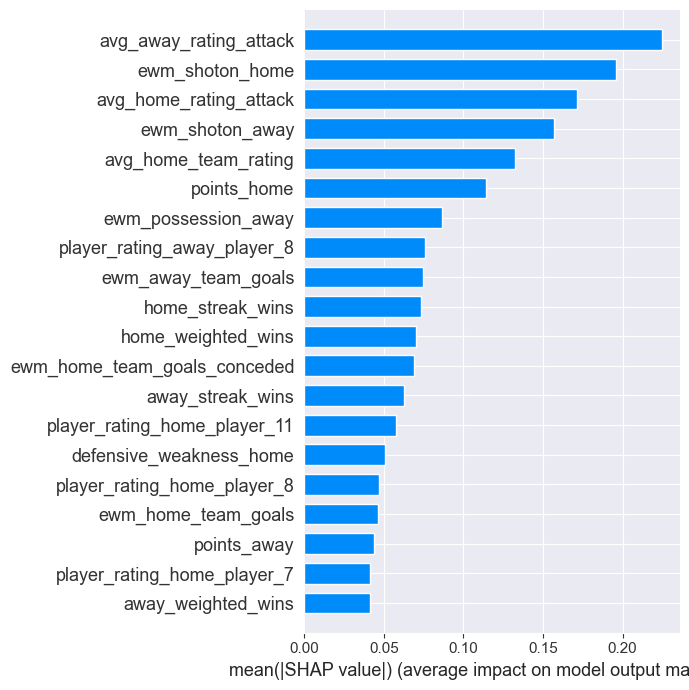

In [12]:
shap.summary_plot(shap_values_XGBoost_train, X_train, plot_type="bar",plot_size=(7,7))

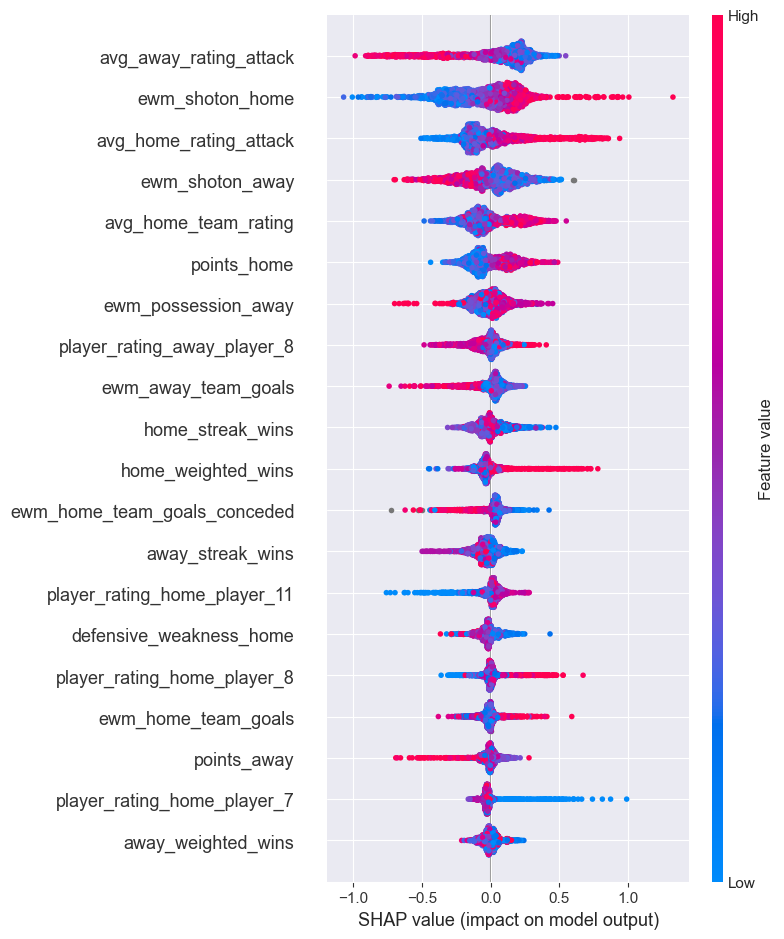

In [13]:
fig = plt.subplots(figsize=(6,6))
ax = shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot")

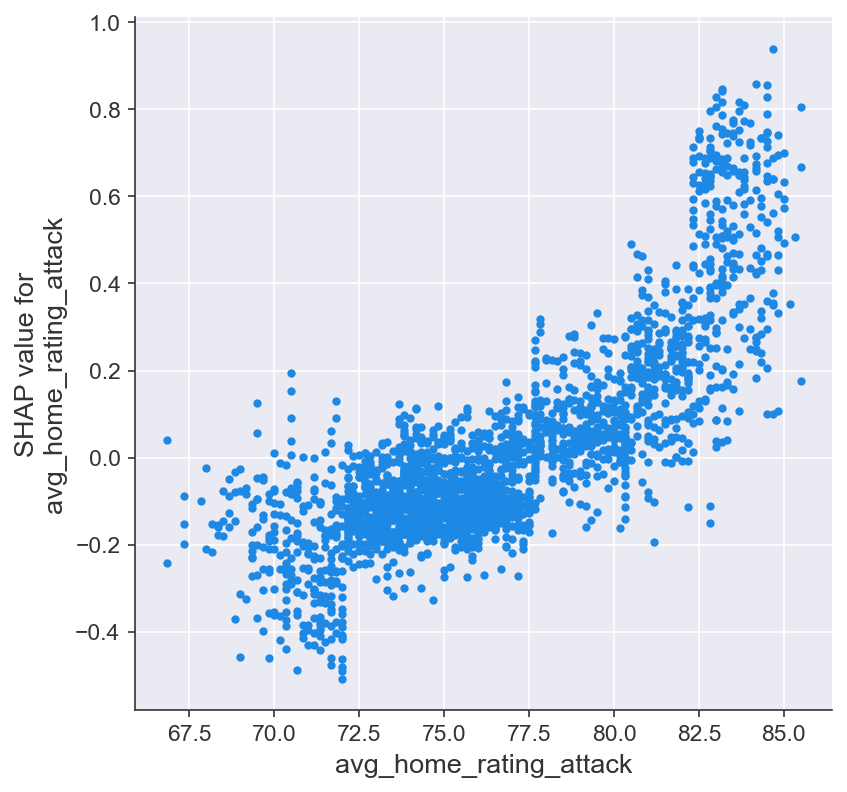

In [14]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)
shp_plt = shap.dependence_plot("avg_home_rating_attack", shap_values_XGBoost_train, X_train,ax=ax1, interaction_index=None)

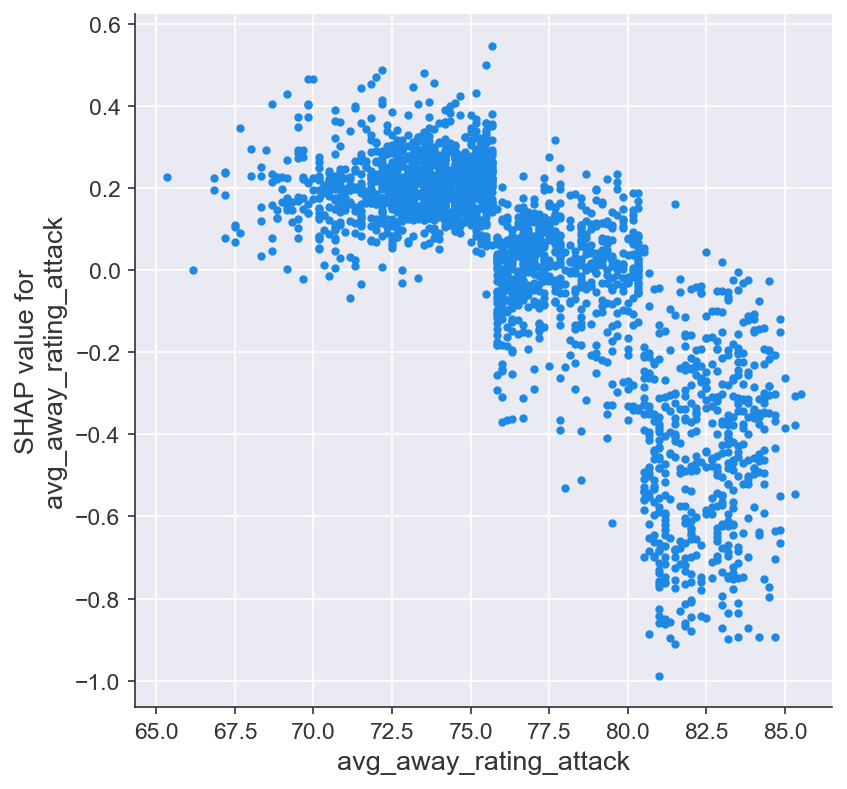

In [15]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)
shp_plt = shap.dependence_plot("avg_away_rating_attack", shap_values_XGBoost_train, X_train,ax=ax1, interaction_index=None)

In [16]:
print(f'Expected Value-Base Value: {explainerxgb.expected_value}')

Expected Value-Base Value: 0.559763491153717


In [17]:
# 8 15
y_pred[8]

1

In [18]:
y_train.iloc[8]

result_match    0
Name: 1528, dtype: int64

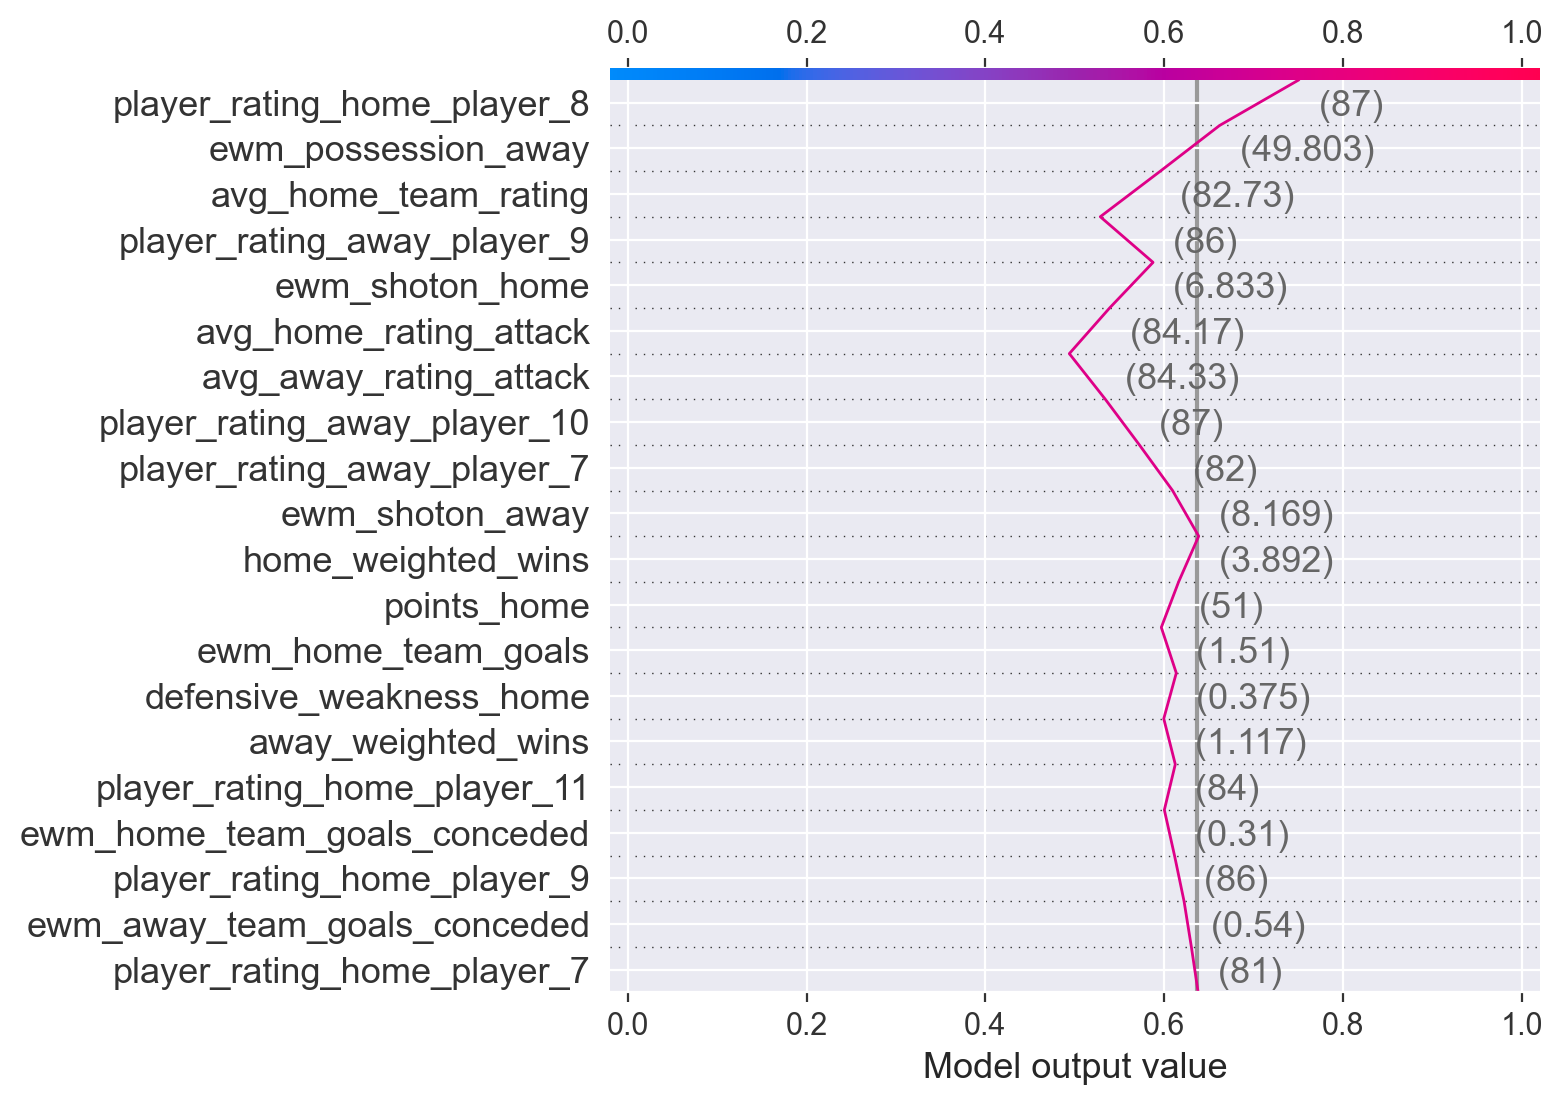

In [19]:
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_1= shap.decision_plot(explainerxgb.expected_value, shap_values_XGBoost_val[8], X_val.iloc[8],auto_size_plot=False, link= "logit")